# Lab 3: Usos más avanzados de Stable Diffusion 🧑‍🔬

Referencias:

- [In-painting pipeline for Stable Diffusion using 🧨 Diffusers - Google Colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb#scrollTo=hvdHYdtTu6KA)
- [InstructPix2Pix: Learning to Follow Image Editing Instructions - 🤗 Hugging Face](https://huggingface.co/timbrooks/instruct-pix2pix)

## Parte 1: Inpainting, OutPainting, Instruct Pix 2 Pix

In [1]:
!pip install -q -U transformers diffusers==0.14.0 accelerate ftfy sentencepiece fpuna-stable-diffusion gradio

### 1.1. Inpainting 🎨

El `StableDiffusionInpaintPipeline` nos permite modificar partes específicas de una imagen incluyendo una máscara y un texto. Utiliza una versión de Stable Diffusion específicamente entrenado para Inpainting.

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch

model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to("cuda")

Descargamos nuestra imagen de prueba y la máscara que vamos a utilizar.

In [3]:
from fpuna_stable_diffusion.utils import image_grid, download_image

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

Como se puede ver, tenemos a un perro sentado en una banca. En nuestra máscara solo seleccionamos al perro para editarlo.

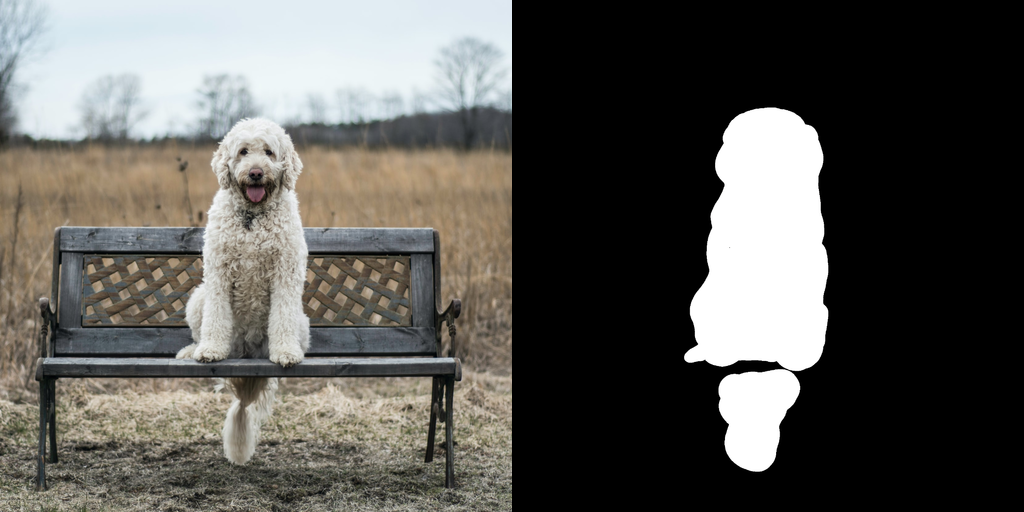

In [4]:
image_grid([image, mask_image], rows=1, cols=2)

Probemos cambiar al perro por un robot, en este caso usaremos el texto "a mecha robot sitting on a bench" que significa "un robot mecha sentado sobre una banca"

In [5]:
prompt = "a mecha robot sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # Cambia la semilla para tener diferentes resultados

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

Veamos los resultados del Inpainting 🎨

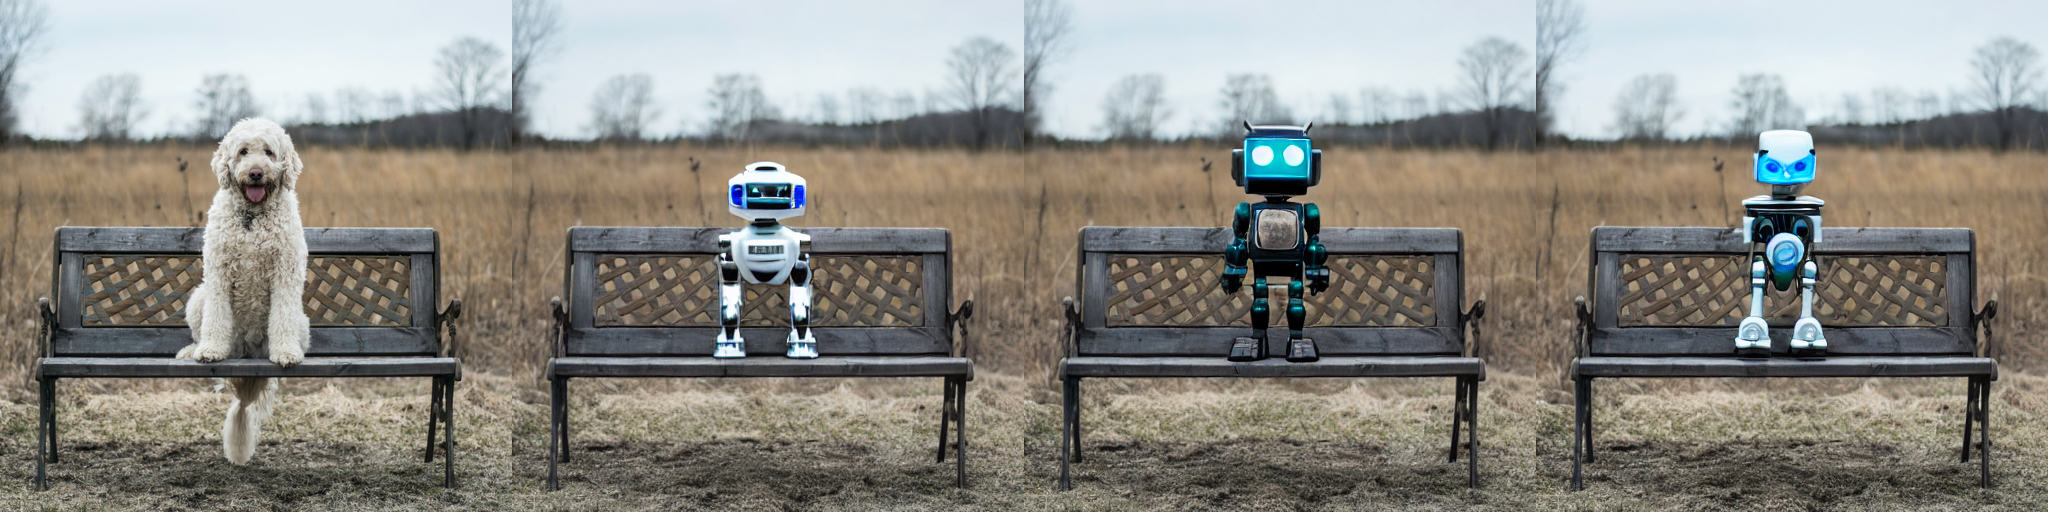

In [6]:
# Insertamos la imagen inicial para comparar
images.insert(0, image)
image_grid(images, 1, num_samples + 1)

Para subir nuestra propia imagen y crear la máscara, podemos usar una herramienta llamada gradio. [Gradio](https://gradio.app/) es una librería que permite crear interfaces web facílmente para los modelos de Machine Learning. Para usar, primero debemos crear nuestra función de predicción.

In [7]:
def predict(dict, prompt):
    # Procesamos la imagen
    image =  dict['image'].convert("RGB").resize((512, 512))
    # Procesamos la máscara
    mask_image = dict['mask'].convert("RGB").resize((512, 512))
    # Ejecutamos el modelo
    images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
    # Retornamos el resultado
    return(images[0])

Para crear la interfaz, debemos pasar nuestra función de predicción, un título, las entradas (imagen, máscara y texto) y la salida. Con gradio se va a generar un URL que nos permitirá compartir el modelo y funcionará mientras el cuaderno este activo. Nota que si apagamos el cuaderno o cambiamos el modelo, la interfaz dejará de funcionar.

In [8]:
import gradio as gr

gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://3e50a8664467dfe097.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


### 1.2. OutPainting 🖼

Una de las ventajas del Inpainting es que podríamos tener una imagen y expandirla afuera de sus fronteras. Para esto, tratamos al exterior de la imagen como la máscara. Usemos al ejemplo del perro, achiquemos la imagen para mantener la resolución.

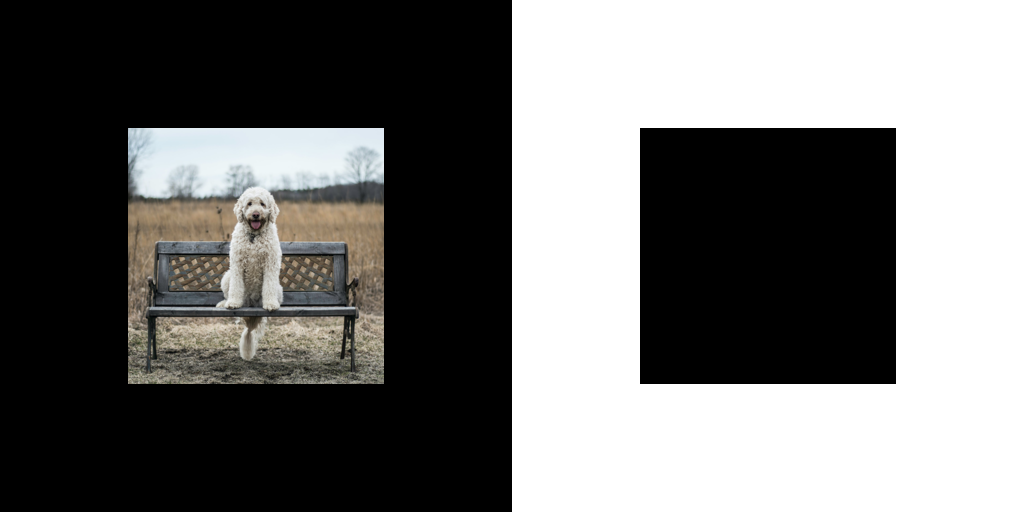

In [9]:
from fpuna_stable_diffusion.utils import agregar_margen

imagen_out, mascara = agregar_margen(image.resize((256, 256)))
image_grid([imagen_out, mascara], rows=1, cols=2)

Procedemos a hacer el outpainting.

  0%|          | 0/50 [00:00<?, ?it/s]

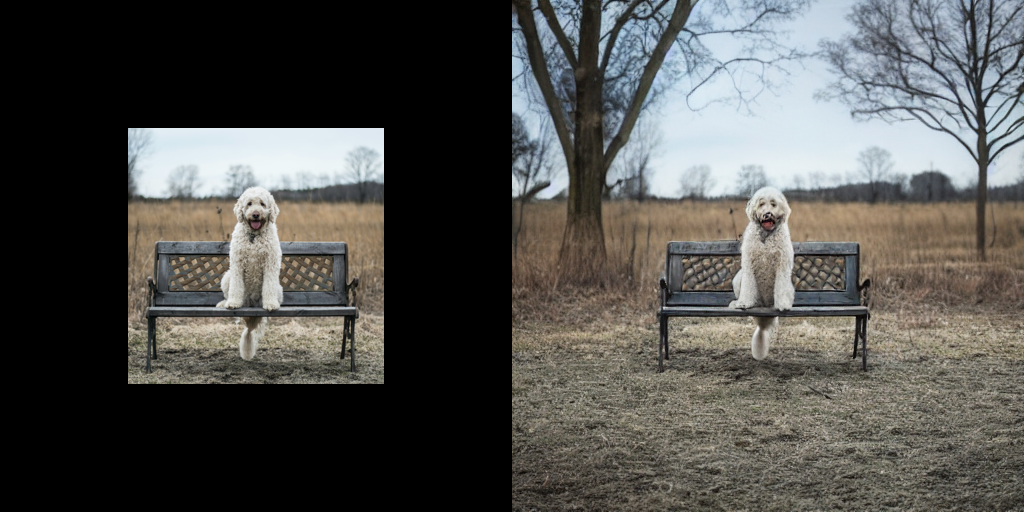

In [10]:
prompt = "a dog sitting on a bench"

generator = torch.Generator(device="cuda").manual_seed(2)

outpainted_image = pipe(
    prompt=prompt,
    image=imagen_out,
    mask_image=mascara,
    generator=generator
).images[0]

image_grid([imagen_out, outpainted_image], rows=1, cols=2)

Vemos que completa parte del paisaje mientras mantiene la coherencia, sin embargo podemos notar que pierde un poco de calidad la imagen original. Probemos copiar y pegar encima de la nueva imagen la foto original para ver si se arregla el problema. Notamos que se puede ver unas líneas

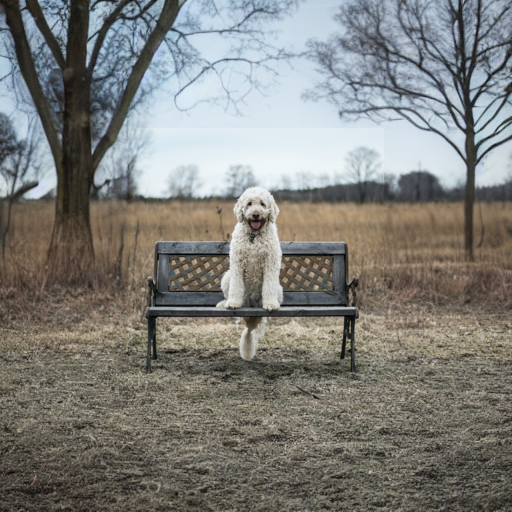

In [11]:
outpainted_image.paste(image.resize((256, 256)), (128, 128))
outpainted_image

### 1.3. Instruct Pix 2 Pix 🌆 ➡️ 🌃

Stable Diffusion también nos permite modificar imágenes sin introducir una máscara por medio de `StableDiffusionInstructPix2PixPipeline`. Por medio de instrucciones podemos modificar objetos de la imagen. 

In [12]:
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Por ejemplo, volvamos de noche la escena del perro. ("make it night") 🌃

In [13]:
prompt = "make it night"
generator = torch.Generator(device="cuda").manual_seed(0)

instruct_img = pipe(prompt,
    image=image,
    num_inference_steps=10,
    generator=generator,
    image_guidance_scale=1).images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

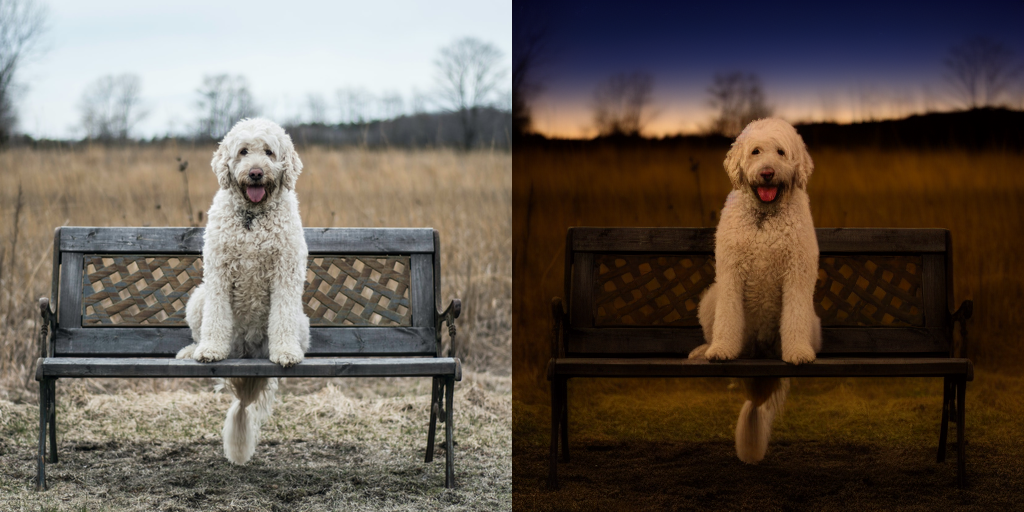

In [14]:
image_grid([image, instruct_img], rows=1, cols=2)